# Preprocesamiento
---
En este notebook se realizará el preprocesamiento de dos conjuntos de datos  


In [40]:
# Importamos los paquetes necesarios
import numpy as np
import pandas as pd

## Preprocesamiento db1
---
Se realiza el preprocesamiento de la base de datos [Total Sediment Thickness of the World's Oceans and Marginal Seas Version 3 (GlobSed)](https://www.ngdc.noaa.gov/mgg/sedthick/data/version3/GlobSed.zip)

In [41]:
# Leyendo el archivo CSV y almacenándolo en el DataFrame 'db1'
db1 = pd.read_csv('/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/IHFC_2023_GHFDB.csv',
                  sep=';', encoding="ISO-8859-1")
# Mostrando las primeras filas del DataFrame
db1.head()

/tmp/ipykernel_79652/2638929737.py:2: DtypeWarning: Columns (2,3,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  db1 = pd.read_csv('/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/IHFC_2023_GHFDB.csv',


,ID,q,q_unc,name,lat,lng,elevation,Ref_1,q_acq,env,...,tc_pTfunc,tc_numb,tc_strategy,Ref_ISGN,A_dom,A_reg,A_cont,A_year,Unnamed: 63,Unnamed: 64
0,1.0,201.0,NaN,C21-3F,-16.0733,-17.2717,-3855.9,Abbott_2008,NaN,NaN,...,NaN,NaN,NaN,NaN,marine,South Atlantic Ocean,South American Plate,2008.0,NaN,NaN
1,2.0,214.0,NaN,C21-3G,-16.0733,-17.2717,-3855.9,Abbott_2008,NaN,NaN,...,NaN,NaN,NaN,NaN,marine,South Atlantic Ocean,South American Plate,2008.0,NaN,NaN
2,3.0,46.0,NaN,C27-3C,-0.9917,81.3983,-4720.3,Abbott_2008,NaN,NaN,...,NaN,NaN,NaN,NaN,marine,Indian Ocean,Indo-Australian Plate,2008.0,NaN,NaN
3,4.0,57.0,NaN,C27-3D,-0.9917,81.3983,-4720.3,Abbott_2008,NaN,NaN,...,NaN,NaN,NaN,NaN,marine,Indian Ocean,Indo-Australian Plate,2008.0,NaN,NaN
4,5.0,176.0,NaN,EL21-10A,-39.9900,-109.8550,-3194.4,Abbott_2008,NaN,NaN,...,NaN,NaN,NaN,NaN,marine,South Pacific Ocean,Antarctic Plate,2008.0,NaN,NaN


In [42]:
print(f'n de filas:{db1.shape[0]} y n de columnas: {db1.shape[1]}')

n de filas:74547 y n de columnas: 65


### Selección de variables
---
Seleccionamos las variables de interés

In [43]:
# Lista de variables seleccionadas
vars_selection = ['q','lat','lng','elevation','A_dom','A_reg','A_cont','A_year']
# Seleccionar las variables del DataFrame db1
db1_select = db1[vars_selection]
# Obtener la forma (número de filas y columnas) del DataFrame seleccionado
db1_select.shape

(74547, 8)

In [44]:
# Seleccionamos datos de flujo de calor marinos
db1_select = db1_select[db1_select['A_dom']=='marine']
db1_select.shape

(33103, 8)

### Búsqueda de valores nulos
---
Eliminamos las filas con valores nulos en nuestra variable de interés *Flujo de calor (q)*. 

In [45]:
# Contamos la cantidad de valores nulos
db1_select.isnull().sum()

q              0
lat            0
lng            0
elevation    603
A_dom          0
A_reg          0
A_cont         0
A_year         0
dtype: int64

In [46]:
# Eliminamos los valores nulos respecto a q
db1_nonull = db1_select.dropna()
# Shape despues de eliminar valores nulos
print(f'n de filas:{db1_nonull.shape[0]} y n de columnas: {db1_nonull.shape[1]}')

n de filas:32500 y n de columnas: 8


In [68]:
# Contamos la cantidad de valores nulos despues de elimninar los de q
db1_nonull.isnull().sum()

q            0
lat          0
lng          0
elevation    0
A_dom        0
A_reg        0
A_cont       0
A_year       0
dtype: int64

### Tipo da datos
---
Se inspecciona los tipos de datos que se tienen para cada variable. 

In [48]:
# Inspeccionamos inconsistencia en la tipologia de los datos 
db1_nonull.dtypes

q            float64
lat          float64
lng          float64
elevation     object
A_dom         object
A_reg         object
A_cont        object
A_year       float64
dtype: object

La variable `elavation` presenta inconsistencias dado que esta debe ser un valor numérico y no carácter. Por tanto, podemos buscar valores no numéricos que estén en dicha columna.

In [49]:
# Patron regex para coincidir caracteres no digitos
pattern = r'^\D+$' 
# Busca cada fila de la columna elevation para verificar si no es digito
col_elev_nodigi = db1_nonull[db1_nonull['elevation'].str.contains(pattern, na=False)]['elevation']
print(f'Non digit values in col elevation: {col_elev_nodigi.shape}')
# Valores unicos de los valores no digitos
nodig_vals = col_elev_nodigi.unique().tolist()
print(f'Valores no digitos encontrados en la columna elevation: \n{nodig_vals}')

Non digit values in col elevation: (26,)
Valores no digitos encontrados en la columna elevation: 
['Not specified', 'Unspecified']


In [50]:
# Filtrar filas que no contienen valores no deseados ['?', 'Not specified', 'Unspecified'] en la columna 'elevation'
db1_nodig = db1_nonull[~db1_nonull['elevation'].isin(nodig_vals)]
# Reemplazar comas por puntos en la columna 'elevation' y convertir los valores a tipo float
db1_nodig['elevation'] = (db1_nodig['elevation']
                          .apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
                          .astype(float))
# Convertir la columna 'A_year' a tipo int
db1_nodig['A_year'] = db1_nodig['A_year'].astype(int)
# Mostrar los tipos de datos de cada columna en el DataFrame db1_nodig
db1_nodig.dtypes

/tmp/ipykernel_79652/1382551165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db1_nodig['elevation'] = (db1_nodig['elevation']
/tmp/ipykernel_79652/1382551165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db1_nodig['A_year'] = db1_nodig['A_year'].astype(int)


q            float64
lat          float64
lng          float64
elevation    float64
A_dom         object
A_reg         object
A_cont        object
A_year         int64
dtype: object

In [51]:
db1_prep = db1_nodig

### Guardamos y versionamos el conjunto de datos db1

In [52]:
db1_prep.to_csv('/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/IHFC_2023_GHFDB_pre.csv', index=False)

In [1]:
!cd /home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition && ls -a && dvc add IHFC_2023_GHFDB_pre.csv

.	     .gitignore       IHFC_2023_GHFDB.csv
..	     GlobSed.zip      IHFC_2023_GHFDB.csv.dvc
get_data.py  GlobSed.zip.dvc  IHFC_2023_GHFDB_pre.csv
⠋ Checking graph                                                 
Adding...                                                                       
!
  0% Checking cache in '/home/mofoko/Documents/Metodologias/tdsp_template/.dvc/c
                                                                                
!
  0%|          |Transferring                          0/? [00:00<?,     ?file/s]
  0%|          |Transferring                          0/1 [00:00<?,     ?file/s]
                                                                                
!
  0%|          |Checking out IHFC_2023_GHFDB_pre.csv  0/? [00:00<?,    ?files/s]
  0%|          |Checking out IHFC_2023_GHFDB_pre.csv  0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 41.32file/s]

To track the changes with git, run:

	git add .giti

## Preprocesamiento db2
---
Este conjunto de datos requiere de un preprocesamiento diferente dado que no son datos estructurados. Se presenta entonces el preprocesamiento necesario para el conjunto de datos [Total Sediment Thickness of the World's Oceans and Marginal Seas Version 3 (GlobSed)](https://www.ngdc.noaa.gov/mgg/sedthick/data/version3/GlobSed.zip)

In [55]:
# Importamos los paquetes necesarios
import zipfile
import os
import xarray as xr
import matplotlib.pyplot as plt

### Descomprimimos los datos
---

In [3]:
# Definimos las rutas para la extraccion del archivo netcdf
zip_path = '/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/GlobSed.zip'
file_to_extract = 'GlobSed/GlobSed_package3/GlobSed-v3.nc'
destination_path = '/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/'
# Extraemos el archivo a una carpeta temporal
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(file_to_extract, destination_path)

In [14]:
os.environ['source'] = "/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/GlobSed/GlobSed_package3/GlobSed-v3.nc"
os.environ['dest'] = "/home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/GlobSed-v3.nc"
!mv $source $dest
!rm -r /home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/GlobSed

In [17]:
!dvc add /home/mofoko/Documents/Metodologias/tdsp_template/scripts/data_acquisition/GlobSed-v3.nc

⠋ Checking graph                                                 
Adding...                                                                       
!
  0% Checking cache in '/home/mofoko/Documents/Metodologias/tdsp_template/.dvc/c
                                                                                
!
  0%|          |Transferring                          0/? [00:00<?,     ?file/s]
  0%|          |Transferring                          0/1 [00:00<?,     ?file/s]
                                                                                
!
  0%|          |Checking out ../data_acquisition/GlobS0/? [00:00<?,    ?files/s]
  0%|          |Checking out ../data_acquisition/GlobS0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 29.13file/s]

To track the changes with git, run:

	git add ../data_acquisition/GlobSed-v3.nc.dvc ../data_acquisition/.gitignore

To enable auto staging, run:

	dvc config core.autostage true


### Selección de datos
---
Extraemos los datos de grosor sedimentario que coincidan con las coordenadas de los puntos con datos de flujo de calor para posteriormente fusionar estos dos conjuntos de datos en un `dataframe`.

In [58]:
# Cargamos los datos
db2_path = '/home/mofoko/Documents/Metodologias/data_proyect/GlobSed/GlobSed_package3/GlobSed-v3.nc' 
db2 = xr.load_dataarray(db2_path)

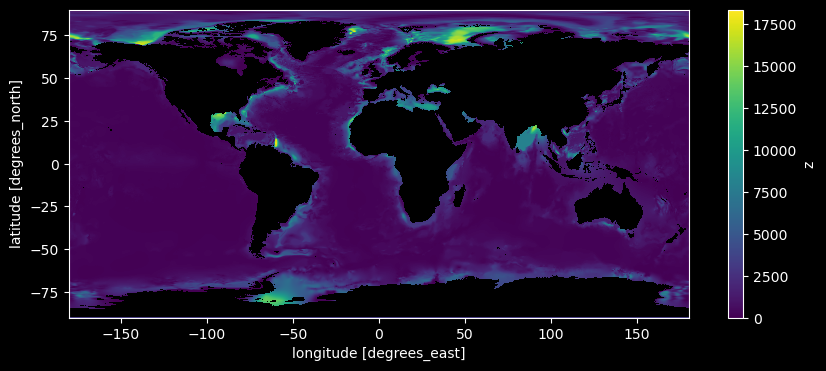

In [59]:
# Visualizamos los datos
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
db2.plot(ax=ax)

In [59]:
list_closest_val = []
for index, row in db1_prep[['lat', 'lng']].iterrows():
    closest_val = db2.sel(lat=row['lat'], lon=row['lng'], method='nearest')
    list_closest_val.append(closest_val.values.tolist())

In [63]:
db12 = db1_prep.copy()
db12['sedthick'] = list_closest_val
db12.head()

,q,lat,lng,elevation,A_dom,A_reg,A_cont,A_year,sedthick
0,201.0,-16.0733,-17.2717,-3855.9,marine,South Atlantic Ocean,South American Plate,2008,85.999977
1,214.0,-16.0733,-17.2717,-3855.9,marine,South Atlantic Ocean,South American Plate,2008,85.999977
2,46.0,-0.9917,81.3983,-4720.3,marine,Indian Ocean,Indo-Australian Plate,2008,1756.000000
3,57.0,-0.9917,81.3983,-4720.3,marine,Indian Ocean,Indo-Australian Plate,2008,1756.000000
4,176.0,-39.9900,-109.8550,-3194.4,marine,South Pacific Ocean,Antarctic Plate,2008,17.999983


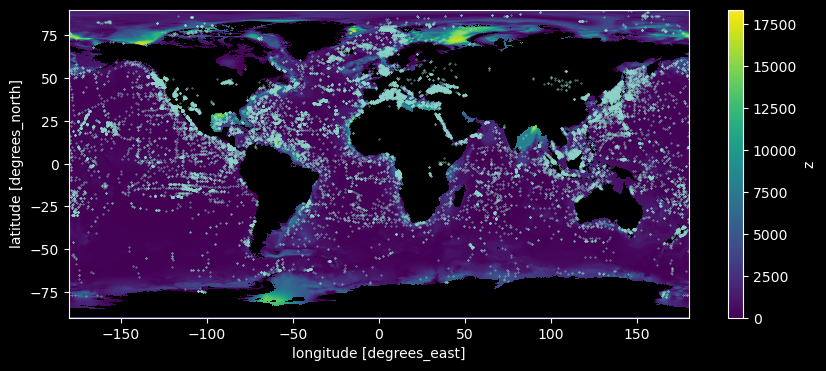

In [64]:
# Visualizamos los datos
fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
db2.plot(ax=ax)
ax.scatter(db12['lng'], db12['lat'], s=.1)

### Búsqueda de valores nulos
---
Revisamos si hay presencia de datos nulos en la variable `sedthick`

In [65]:
# Contamos la cantidad de valores nulos
db12.isnull().sum()

q               0
lat             0
lng             0
elevation       0
A_dom           0
A_reg           0
A_cont          0
A_year          0
sedthick     1543
dtype: int64

In [66]:
# Eliminamos los valores nulos respecto a sedthick
db12_nonull = db12.dropna()
# Shape despues de eliminar valores nulos
print(f'n de filas:{db12_nonull.shape[0]} y n de columnas: {db12_nonull.shape[1]}')

n de filas:30931 y n de columnas: 9


In [69]:
# Contamos la cantidad de valores nulos despues de elimninar los de sedthick
db12_nonull.isnull().sum()

q            0
lat          0
lng          0
elevation    0
A_dom        0
A_reg        0
A_cont       0
A_year       0
sedthick     0
dtype: int64

### Tipo da datos
---
Se inspecciona los tipos de datos que se tienen para cada variable. 

In [70]:
# Inspeccionamos inconsistencia en la tipologia de los datos 
db12_nonull.dtypes

q            float64
lat          float64
lng          float64
elevation    float64
A_dom         object
A_reg         object
A_cont        object
A_year         int64
sedthick     float64
dtype: object

Observamos que la variable `sedthick` presenta el tipo de dato  correcto.